In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [4]:
file_path = Path('Transactions0719.csv')
new_df = pd.read_csv(file_path)
new_df.head()

,Unnamed: 0,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,1619,0,0,2007,1,1,06:48,$146.32,Swipe Transaction,2027553650310142703,Seattle,WA,98148.0,5541,NaN,No
1,1620,0,0,2007,1,2,07:03,$-426.00,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
2,1621,0,0,2007,1,2,07:27,$126.03,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
3,1622,0,0,2007,1,3,06:24,$121.71,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,"Insufficient Balance,",No
4,1623,0,0,2007,1,5,13:06,$13.44,Swipe Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No


In [5]:
new_df.columns = new_df.columns.str.replace(' ', '')
new_df

,Unnamed:0,User,Card,Year,Month,Day,Time,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Errors?,IsFraud?
0,1619,0,0,2007,1,1,06:48,$146.32,Swipe Transaction,2027553650310142703,Seattle,WA,98148.0,5541,NaN,No
1,1620,0,0,2007,1,2,07:03,$-426.00,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
2,1621,0,0,2007,1,2,07:27,$126.03,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
3,1622,0,0,2007,1,3,06:24,$121.71,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,"Insufficient Balance,",No
4,1623,0,0,2007,1,5,13:06,$13.44,Swipe Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20218445,24386727,1999,1,2019,12,30,11:38,$66.53,Chip Transaction,2910328604019547969,Milford,NH,3055.0,7538,NaN,No
20218446,24386728,1999,1,2019,12,30,12:03,$99.67,Chip Transaction,1641456720718814353,Merrimack,NH,3054.0,5411,NaN,No
20218447,24386729,1999,1,2019,12,30,18:44,$93.63,Chip Transaction,-5501892381419303127,Merrimack,NH,3054.0,5651,NaN,No
20218448,24386730,1999,1,2019,12,30,20:09,$67.60,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


In [6]:
new_df['IsFraud?'].value_counts()

No     20191733
Yes       26717
Name: IsFraud?, dtype: int64

In [7]:
new_df.isna().sum()

Unnamed:0               0
User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  0
UseChip                 0
MerchantName            0
MerchantCity            0
MerchantState     2364496
Zip               2494240
MCC                     0
Errors?          19897996
IsFraud?                0
dtype: int64

In [8]:
new_df

,Unnamed:0,User,Card,Year,Month,Day,Time,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Errors?,IsFraud?
0,1619,0,0,2007,1,1,06:48,$146.32,Swipe Transaction,2027553650310142703,Seattle,WA,98148.0,5541,NaN,No
1,1620,0,0,2007,1,2,07:03,$-426.00,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
2,1621,0,0,2007,1,2,07:27,$126.03,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
3,1622,0,0,2007,1,3,06:24,$121.71,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,"Insufficient Balance,",No
4,1623,0,0,2007,1,5,13:06,$13.44,Swipe Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20218445,24386727,1999,1,2019,12,30,11:38,$66.53,Chip Transaction,2910328604019547969,Milford,NH,3055.0,7538,NaN,No
20218446,24386728,1999,1,2019,12,30,12:03,$99.67,Chip Transaction,1641456720718814353,Merrimack,NH,3054.0,5411,NaN,No
20218447,24386729,1999,1,2019,12,30,18:44,$93.63,Chip Transaction,-5501892381419303127,Merrimack,NH,3054.0,5651,NaN,No
20218448,24386730,1999,1,2019,12,30,20:09,$67.60,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


In [9]:
new_df.columns

Index(['Unnamed:0', 'User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount',
       'UseChip', 'MerchantName', 'MerchantCity', 'MerchantState', 'Zip',
       'MCC', 'Errors?', 'IsFraud?'],
      dtype='object')

In [10]:
list(new_df.describe())

['Unnamed:0',
 'User',
 'Card',
 'Year',
 'Month',
 'Day',
 'MerchantName',
 'Zip',
 'MCC']

In [11]:
new_df['Amount'] = pd.to_numeric(new_df['Amount'].str.replace('$', ''))
new_df

,Unnamed:0,User,Card,Year,Month,Day,Time,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Errors?,IsFraud?
0,1619,0,0,2007,1,1,06:48,146.32,Swipe Transaction,2027553650310142703,Seattle,WA,98148.0,5541,NaN,No
1,1620,0,0,2007,1,2,07:03,-426.00,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
2,1621,0,0,2007,1,2,07:27,126.03,Swipe Transaction,-8566951830324093739,Puyallup,WA,98373.0,3640,NaN,No
3,1622,0,0,2007,1,3,06:24,121.71,Swipe Transaction,-34551508091458520,La Verne,CA,91750.0,5912,"Insufficient Balance,",No
4,1623,0,0,2007,1,5,13:06,13.44,Swipe Transaction,-4500542936415012428,La Verne,CA,91750.0,5814,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20218445,24386727,1999,1,2019,12,30,11:38,66.53,Chip Transaction,2910328604019547969,Milford,NH,3055.0,7538,NaN,No
20218446,24386728,1999,1,2019,12,30,12:03,99.67,Chip Transaction,1641456720718814353,Merrimack,NH,3054.0,5411,NaN,No
20218447,24386729,1999,1,2019,12,30,18:44,93.63,Chip Transaction,-5501892381419303127,Merrimack,NH,3054.0,5651,NaN,No
20218448,24386730,1999,1,2019,12,30,20:09,67.60,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No


In [12]:
cols_to_keep = ['Amount', 'Card', 'Year', 'Month', 'Day', 'MCC', 'IsFraud?']

In [13]:
new_df['UseChip'].value_counts()

Swipe Transaction     11809566
Chip Transaction       6051735
Online Transaction     2357149
Name: UseChip, dtype: int64

In [14]:
usechip_dummies_df = pd.get_dummies(new_df['UseChip'])

In [15]:
model_df = new_df[cols_to_keep]
model_df

,Amount,Card,Year,Month,Day,MCC,IsFraud?
0,146.32,0,2007,1,1,5541,No
1,-426.00,0,2007,1,2,3640,No
2,126.03,0,2007,1,2,3640,No
3,121.71,0,2007,1,3,5912,No
4,13.44,0,2007,1,5,5814,No
...,...,...,...,...,...,...,...
20218445,66.53,1,2019,12,30,7538,No
20218446,99.67,1,2019,12,30,5411,No
20218447,93.63,1,2019,12,30,5651,No
20218448,67.60,1,2019,12,30,4121,No


In [16]:
usechip_dummies_df.shape

(20218450, 3)

In [17]:
new_df.shape

(20218450, 16)

In [18]:
# the model that is ready for XGBoost and resampling
model_df = pd.concat([model_df, usechip_dummies_df], axis = 1)
model_df

,Amount,Card,Year,Month,Day,MCC,IsFraud?,Chip Transaction,Online Transaction,Swipe Transaction
0,146.32,0,2007,1,1,5541,No,0,0,1
1,-426.00,0,2007,1,2,3640,No,0,0,1
2,126.03,0,2007,1,2,3640,No,0,0,1
3,121.71,0,2007,1,3,5912,No,0,0,1
4,13.44,0,2007,1,5,5814,No,0,0,1
...,...,...,...,...,...,...,...,...,...,...
20218445,66.53,1,2019,12,30,7538,No,1,0,0
20218446,99.67,1,2019,12,30,5411,No,1,0,0
20218447,93.63,1,2019,12,30,5651,No,1,0,0
20218448,67.60,1,2019,12,30,4121,No,0,1,0


In [19]:
model_df['IsFraud?'].value_counts()

No     20191733
Yes       26717
Name: IsFraud?, dtype: int64

In [20]:
#Looking for the amount of "yes" and 'no' fraudulent transactions for each year
for year in new_df['Year'].unique():
    print(year, new_df[new_df['Year']==year]['IsFraud?'].value_counts())

2007 No     1062602
Yes       1881
Name: IsFraud?, dtype: int64
2008 No     1219750
Yes       3710
Name: IsFraud?, dtype: int64
2009 No     1354294
Yes       1140
Name: IsFraud?, dtype: int64
2010 No     1487390
Yes       3835
Name: IsFraud?, dtype: int64
2011 No     1570496
Yes         55
Name: IsFraud?, dtype: int64
2012 No     1609496
Yes       1333
Name: IsFraud?, dtype: int64
2013 No     1648899
Yes       2018
Name: IsFraud?, dtype: int64
2014 No     1671291
Yes       1052
Name: IsFraud?, dtype: int64
2015 No     1698090
Yes       3281
Name: IsFraud?, dtype: int64
2016 No     1705345
Yes       3579
Name: IsFraud?, dtype: int64
2017 No     1723105
Yes        255
Name: IsFraud?, dtype: int64
2018 No     1719124
Yes       2491
Name: IsFraud?, dtype: int64
2019 No     1721851
Yes       2087
Name: IsFraud?, dtype: int64


## Target Variable Class Distribution

In [21]:
import matplotlib.pyplot as plt

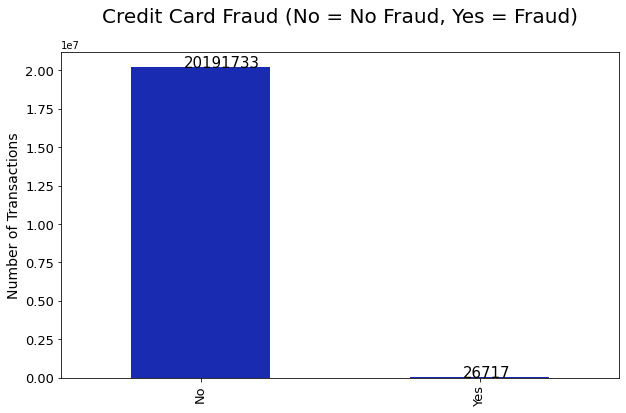

In [22]:
ax = model_df['IsFraud?'].value_counts().plot(kind = "bar", figsize = (10, 6), fontsize=13, color="#192bb0")
ax.set_title("Credit Card Fraud (No = No Fraud, Yes = Fraud)", size=20, pad=30)
ax.set_ylabel("Number of Transactions", fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)


In [23]:
# Change the stringd column
def change_string(Fraud):
    if Fraud == 'Yes':
        return 1
    else:
        return 0

model_df["IsFraud?"] = model_df["IsFraud?"].apply(change_string)
model_df.head()

,Amount,Card,Year,Month,Day,MCC,IsFraud?,Chip Transaction,Online Transaction,Swipe Transaction
0,146.32,0,2007,1,1,5541,0,0,0,1
1,-426.00,0,2007,1,2,3640,0,0,0,1
2,126.03,0,2007,1,2,3640,0,0,0,1
3,121.71,0,2007,1,3,5912,0,0,0,1
4,13.44,0,2007,1,5,5814,0,0,0,1


In [24]:
#looking for how many different card values there are (What do the values mean?)
for card in model_df['Card'].unique():
    print(card, model_df[model_df['Card']==card]['Card'].value_counts())

0 0    7397425
Name: Card, dtype: int64
1 1    5350442
Name: Card, dtype: int64
2 2    3609532
Name: Card, dtype: int64
3 3    2251984
Name: Card, dtype: int64
4 4    993794
Name: Card, dtype: int64
5 5    434885
Name: Card, dtype: int64
6 6    139299
Name: Card, dtype: int64
7 7    36435
Name: Card, dtype: int64
8 8    4654
Name: Card, dtype: int64


In [25]:
X = model_df.copy()
X = X.drop("IsFraud?", axis=1)
y = model_df["IsFraud?"].values

In [26]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X,
   y)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({0: 15143710, 1: 20127})

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [30]:
Counter(y_resampled)

Counter({0: 15143710, 1: 15143710})

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced

In [33]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.75]


for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=10,
                                               learning_rate=learning_rate,
                                               max_features=5,
                                               max_depth=3,
                                               random_state=0)
    classifier.fit(X_train_scaled, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train_scaled,
                                                                       y_train)))
    print("Accuracy score (validation): {0:.3f}".format(classifier.score(X_test_scaled, y_test)))

Learning rate:  0.75
Accuracy score (training): 0.999
Accuracy score (validation): 0.999


## Data Scaling

In [35]:
from sklearn.preprocessing import MinMaxScaler

# We are scaling only colums that have a value greater than 1
to_scale = [col for col in model_df.columns if model_df[col].max() >1]
mms = MinMaxScaler()
scaled = mms.fit_transform(model_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

#replace original colums with scaled ones
for col in scaled:
    model_df[col] = scaled[col]
    
model_df.head()

,Amount,Card,Year,Month,Day,MCC,IsFraud?,Chip Transaction,Online Transaction,Swipe Transaction
0,0.088293,0.0,0.0,0.0,0.000000,0.497985,0,0,0,1
1,0.010109,0.0,0.0,0.0,0.033333,0.250813,0,0,0,1
2,0.085521,0.0,0.0,0.0,0.033333,0.250813,0,0,0,1
3,0.084931,0.0,0.0,0.0,0.066667,0.546223,0,0,0,1
4,0.070140,0.0,0.0,0.0,0.133333,0.533481,0,0,0,1


In [37]:
from sklearn.model_selection import train_test_split

X = model_df.drop("IsFraud?", axis=1)
y = model_df["IsFraud?"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print (f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1]*100,2)}
% Positive Class in Test = {np.round(y_test.value_counts(normalize=True)[1]*100, 2)}''')

% Positive class in Train = 0.13
% Positive Class in Test = 0.13


In [ ]:
# # Import dependecies needed
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# #Train 
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)
# preds = model.predict(X_test)

# #Evaluate
# print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
# cm = confussion_matrix(y_test, preds)
# plt.figure(figsize=(8,6))
# plt.title('Confusion Matrix (without SMOTE)', size =16)
# sns.heatmap(cm, annot=True, cmap="Blues")



In [38]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after Smote: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True)*100

Shape of X before SMOTE: (20218450, 9)
Shape of X after Smote: (40383466, 9)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: IsFraud?, dtype: float64

In [40]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      0.66      0.94      0.77      0.60   5047917
          1       0.01      0.66      0.88      0.01      0.77      0.57      6696

avg / total       1.00      0.88      0.66      0.94      0.77      0.60   5054613



In [ ]:
# # Import dependecies needed
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(
#     X_sm, y_sm, test_size=0.25, random_state=42)

# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)
# preds = model.predict(X_test)

# print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
# cm = confussion_matrix(y_test, preds)
# plt.figure(figsize=(8,6))
# plt.title('Confusion Matrix (with SMOTE)', size =16)
# sns.heatmap(cm, annot=True, cmap="Blues")

In [42]:
pip install shap

     |████████████████████████████████| 356 kB 12.8 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-macosx_10_9_x86_64.whl size=416054 sha256=f0fca50d447974e2e330df8464f5a2087218d5862cf8709f8df572d6c5a7bab3
  Stored in directory: /Users/jonathanfuentes/Library/Caches/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [43]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance
# import shap
# plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
# plt.rcParams.update({'font.size': 14})

In [58]:
# rf = RandomForestRegressor(n_estimators=100)
# rf.fit(X_train, y_train)

RandomForestRegressor()

In [59]:
# rf.feature_importances_

array([0.32648025, 0.0471009 , 0.03868698, 0.06586601, 0.09205529,
       0.42158725, 0.00221441, 0.00375599, 0.00225292])

In [62]:
# plt.barh(cols_to_keep.columns, rf.feature_importances_)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [60]:
# sorted_idx = rf.feature_importances_.argsort()
# plt.barh(rf.feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names'

In [ ]:
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_test)

In [ ]:
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, X_test)

In [36]:
resamp_y_df = pd.DataFrame(y_resampled)
resamp_y_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
30287415,1
30287416,1
30287417,1
30287418,1


In [41]:
resamp_y_df.columns = ['IsFraud?']
resamp_y_df

,IsFraud?
0,0
1,0
2,0
3,0
4,0
...,...
30287415,1
30287416,1
30287417,1
30287418,1


In [42]:
output_df = pd.concat([resamp_y_df, X_resampled], axis=1)


In [43]:
output_df.to_csv('Output_df.csv')

In [44]:
output_df

,IsFraud?,Amount,Card,Year,Month,Day,MCC,Chip Transaction,Online Transaction,Swipe Transaction
0,0,24.54,1,2013,2,15,4784,0,1,0
1,0,4.40,1,2017,8,26,5912,1,0,0
2,0,45.45,0,2007,12,11,5812,0,0,1
3,0,67.00,1,2008,4,12,5541,0,0,1
4,0,42.61,1,2015,5,9,5541,1,0,0
...,...,...,...,...,...,...,...,...,...,...
30287415,1,88.41,0,2010,8,10,5300,0,1,0
30287416,1,20.88,0,2010,2,2,5970,0,1,0
30287417,1,97.15,3,2019,1,15,5211,1,0,0
30287418,1,88.08,4,2010,12,9,4121,0,1,0
